# Exploration of different object detection post-processings

Includes expolration of:
- [greedy NMS](https://xinetai.github.io/CVX/%E7%9B%AE%E6%A0%87%E6%A3%80%E6%B5%8B/papers/NMS.pdf)
-  [temporal NMS](https://projet.liris.cnrs.fr/imagine/pub/proceedings/ICPR-2014/data/5209c239.pdf)
- [soft NMS](http://arxiv.org/pdf/1704.04503v2)

In [1]:
from pathlib import Path
from tqdm import tqdm
import pickle

import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
from sklearn.metrics import auc

import cv2

from data import tf_record_loading as loader
from data import bbox_utils as box

from prediction import prediction_utils as predictor

from statistics import get_performance_metrics
from visualization import draw_circles_from_boxes, plot_circles_from_boxes, write_video, draw_circles_on_image

from procsessing.nms import greedy_nms, soft_nms, t_nms

In [2]:
# Change default plot size
plt.rcParams['figure.figsize'] = [12, 6]

## Load Model and Data

In [3]:
DATA_PATH = "D:\\Nabil_object_detection\\val\\z00_tiles0_bboxes40.tfrecord"
MODEL_PATH = "D:\\Nabil_object_detection\\models\\graph_imgSize_vs_bboxSize\\ssd_resnet50_v1_fpn_10x_tiles0_bboxes40"

In [4]:
data = loader.load_tf_dataset(DATA_PATH)
model = predictor.load_model(MODEL_PATH)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


## Predictions

In [5]:
images = data.get("images")
gt_bboxes = data.get("bboxes")

Prediction can take a while. If you predict for the first time, save predictions as pickle to reuse it for more experiments.

In [6]:
# predictions = []

# for image in tqdm(images):
#     prediction = predictor.run_inference_for_single_image(model, image)
#     predictions.append(prediction)

# pickle.dump(predictions, open("predictions.py", "wb"))

In [7]:
predictions = pickle.load(open("predictions.p", "rb"))

## NMS on every image

### Prediction score vs. NMS

In [8]:
first_prediction = predictions[0].get("detection_boxes")[predictions[0].get("detection_scores") >= 0.0]
first_score = predictions[0].get("detection_scores")[predictions[0].get("detection_scores") >= 0.0]

In [9]:
greedy_scores = greedy_nms(first_prediction, first_score, 0.5)
soft_scores = soft_nms(first_prediction, first_score, 0.5)

In [10]:
greedy_predictions = first_prediction[greedy_scores >= 0.5]
soft_predictions = first_prediction[soft_scores >= 0.5]

In [11]:
prediction_points = box.boxes_to_center_points(first_prediction)
greedy_points = box.boxes_to_center_points(greedy_predictions)
soft_points = box.boxes_to_center_points(soft_predictions)

As can be seen in the image below, soft-NMS keeps more predictions. Especially in clustered areas, only the score gets decreased.

In [12]:
img_threshold = draw_circles_on_image(images[0], prediction_points[first_score >= 0.5], colors=first_score[first_score >= 0.5])
img_nms_vs_soft = draw_circles_on_image(images[0], soft_points, greedy_points)
img_nms_scores = draw_circles_on_image(images[0], greedy_points, colors=greedy_scores[greedy_scores >= 0.5])
img_soft_scores = draw_circles_on_image(images[0], soft_points, colors=soft_scores[soft_scores >= 0.5])

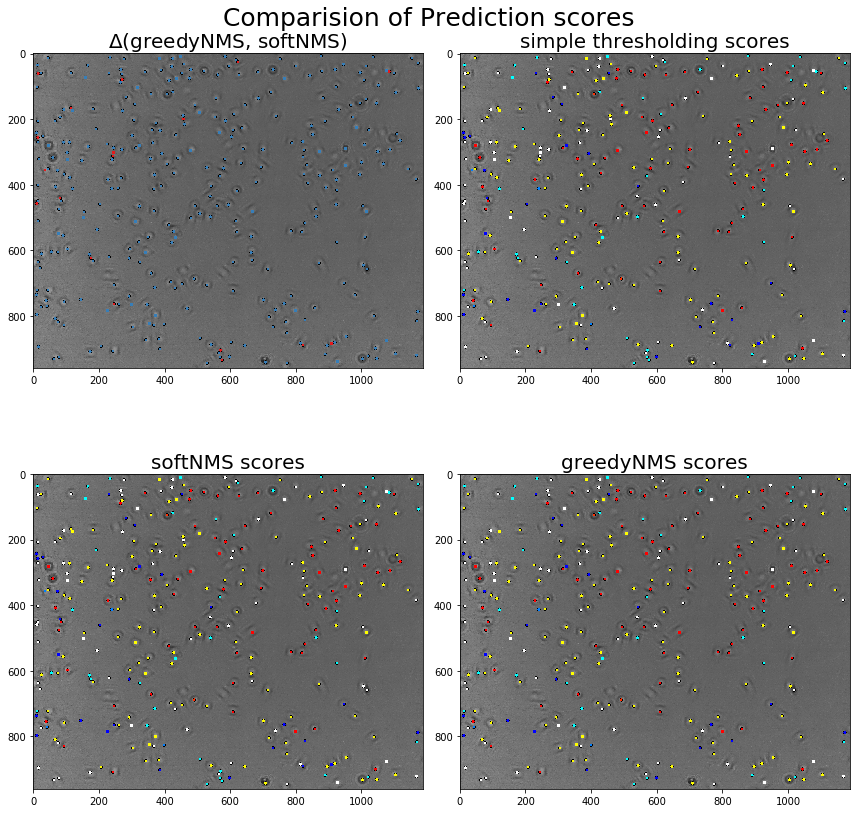

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(12,12))
fig.suptitle("Comparision of Prediction scores", fontsize=25)

# Difference between greedyNMS and softNMS predictions. softNMS in red.
axs[0, 0].set_title("$\Delta$(greedyNMS, softNMS)", fontsize=20)
axs[0, 0].imshow(img_nms_vs_soft)

axs[0, 1].set_title("simple thresholding scores", fontsize=20)
axs[0, 1].imshow(img_threshold)

axs[1, 0].set_title("softNMS scores", fontsize=20)
axs[1, 0].imshow(img_soft_scores)

axs[1, 1].set_title("greedyNMS scores", fontsize=20)
axs[1, 1].imshow(img_nms_scores)

fig.tight_layout()
plt.show()

## Evaluate tNMS

In [14]:
# Get all predicitons
all_detections = [x.get("detection_boxes") for x in predictions]
all_scores = [x.get("detection_scores") for x in predictions]

In [15]:
# Get greedy NMS
greedy_scores = [greedy_nms(p, s, 0.5) for p, s in zip(all_detections, all_scores)]
greedy_detecions = [p[s >= 0.7] for p, s in zip(all_detections, greedy_scores)]

In [16]:
# Get soft NMS
soft_scores = [soft_nms(p, s, 0.5) for p, s in zip(all_detections, all_scores)]
soft_detecions = [p[s >= 0.7] for p, s in zip(all_detections, soft_scores)]

In [17]:
# Get temporal NMS
t_detections, t_scores = t_nms(all_detections, all_scores, iou=0.4)

In [18]:
# Get all metrics

evaluation_metrics = {
    "greedy": [],
    "soft": [],
    "temporal": [],
    "plain": []
}


thresh = 0.7

for i in tqdm(range(len(images))):
    
    greedy_score, soft_score = greedy_scores[i], soft_scores[i]
    t_detection, t_score = t_detections[i], t_scores[i]
    all_detection, all_score = all_detections[i], all_scores[i]
    
    greedy = get_performance_metrics(all_detection[greedy_score >= thresh], gt_bboxes[i], 0.5)
    soft = get_performance_metrics(all_detection[soft_score >= thresh], gt_bboxes[i], 0.5)
    temporal = get_performance_metrics(t_detection[t_score >= thresh], gt_bboxes[i], 0.5)
    plain = get_performance_metrics(all_detection[all_score >= thresh], gt_bboxes[i], 0.5)
    
    
    evaluation_metrics.get("greedy").append(greedy)
    evaluation_metrics.get("soft").append(soft)
    evaluation_metrics.get("temporal").append(temporal)
    evaluation_metrics.get("plain").append(plain)

100%|█████████████████████████████████████████████████████████████████| 75/75 [00:03<00:00, 21.31it/s]


## Visualisation of perfomance metrics

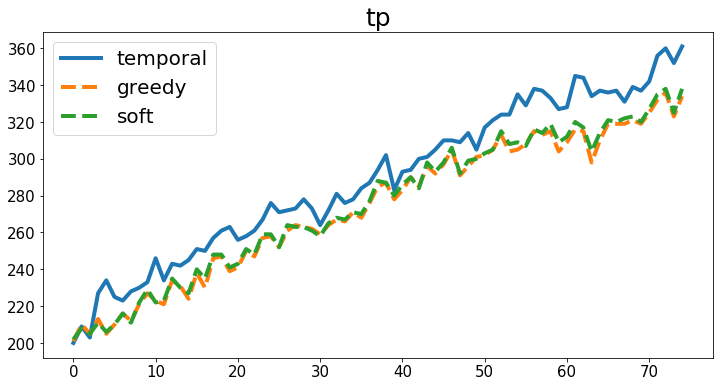

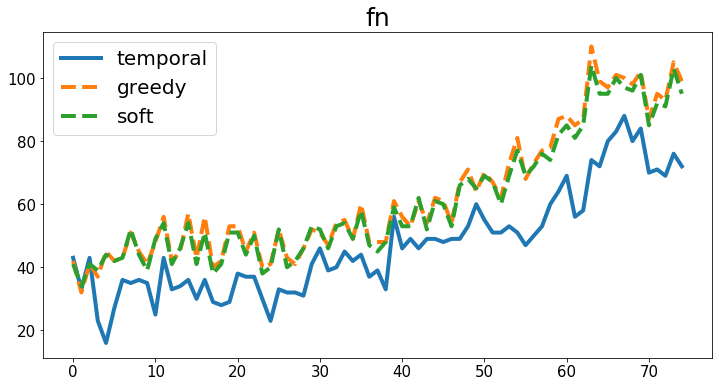

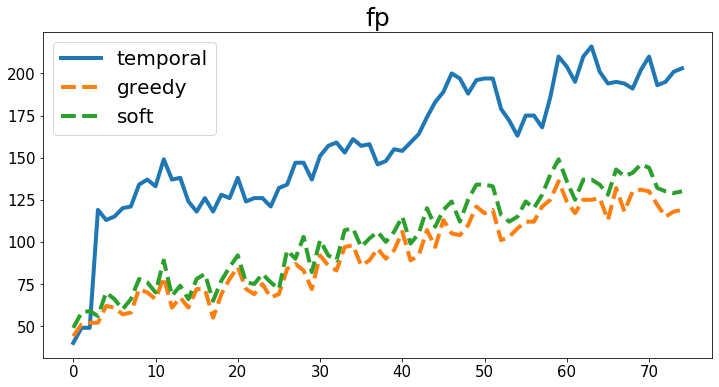

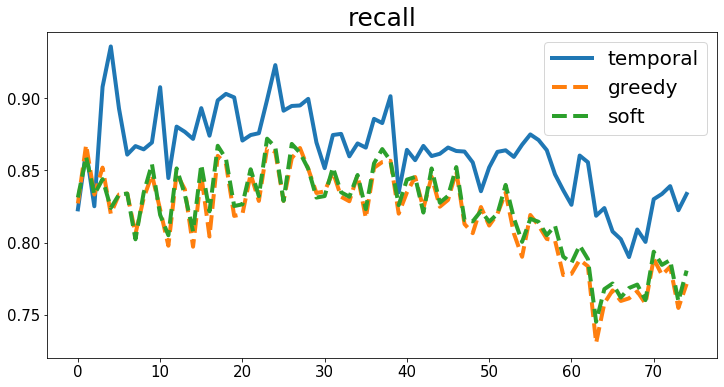

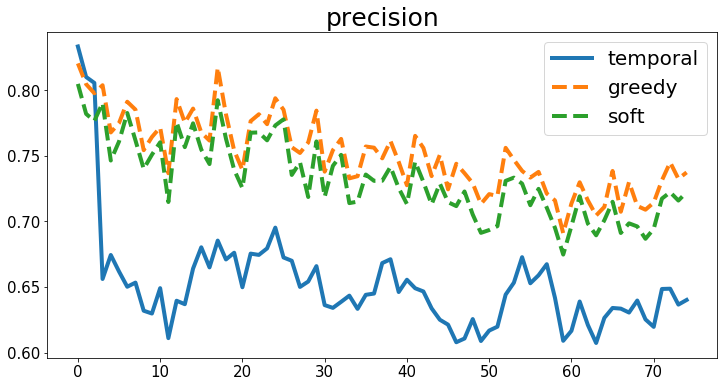

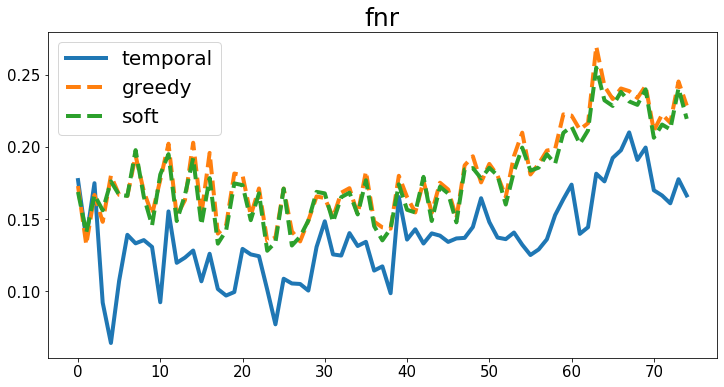

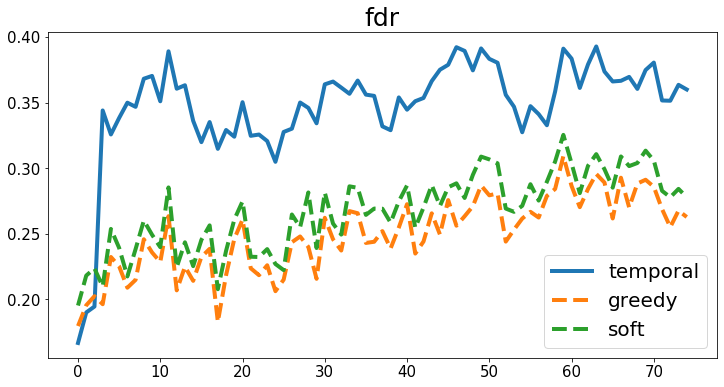

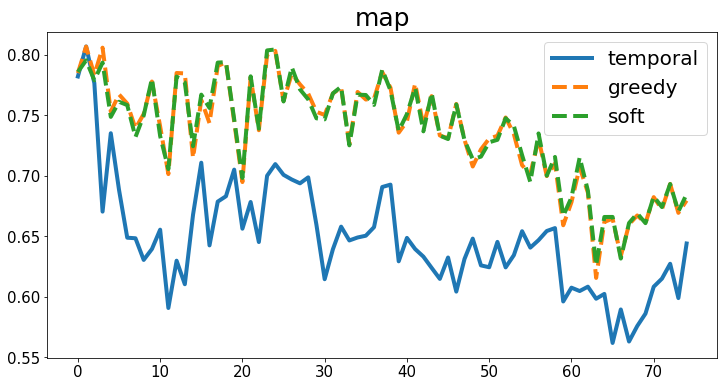

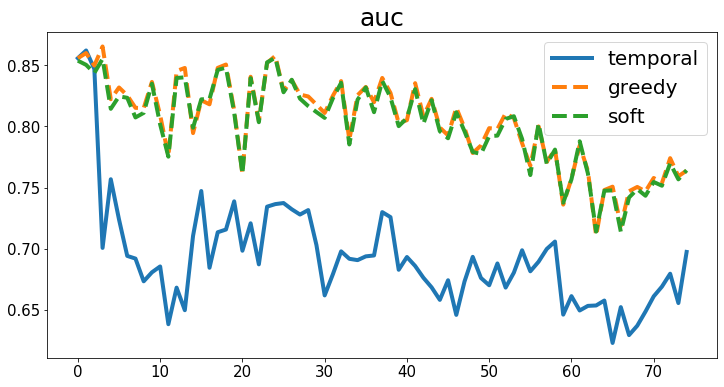

In [21]:
for key in evaluation_metrics.get("soft")[0].keys():
    
    if key in ["recalls", "precisions"]:
        continue
    
    temporal = [evaluation_metrics.get("temporal")[i].get(key) for i in range(len(images))]
    plain = [evaluation_metrics.get("plain")[i].get(key) for i in range(len(images))]
    greedy = [evaluation_metrics.get("greedy")[i].get(key) for i in range(len(images))]
    soft = [evaluation_metrics.get("soft")[i].get(key) for i in range(len(images))]
    
    plt.title(key, fontsize=25)
    plt.plot(temporal, label="temporal", lw=4, linestyle="-")
#     plt.plot(plain, label="plain")
    plt.plot(greedy, label="greedy", lw=4, linestyle="--")
    plt.plot(soft, label="soft", lw=4, linestyle="--")
    plt.legend(fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()